## ARIMA pre-processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Read file and return a pd.Series()

In [2]:
data = pd.read_csv("facebook.csv", index_col=0, squeeze=True)

<AxesSubplot:>

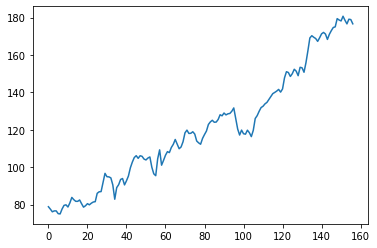

In [3]:

ind = [i for i in range(data.size)]
data.index = ind
data.plot()

## Split the data into a training and test part

In [4]:
# Not using this when index is not a date

# dataTrain = data[:"2017-01-01"]
# dataTrain.plot()

# dataTest = data["2017-01-01":]
# dataTest.plot()


## Do a augmented Dickey-Fuller test

(0.17227611232743184,
 0.9706630685458876,
 2,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 677.9386750403336)

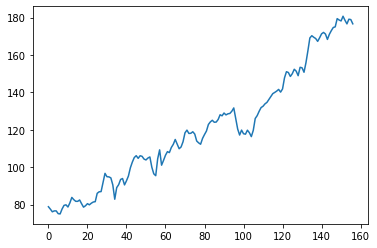

In [5]:
data.plot()
resAd = adfuller(data)
resAd

## And one with a one-lag differences dataset

(-10.307161545864284,
 3.256132261115787e-18,
 1,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 672.1242054140864)

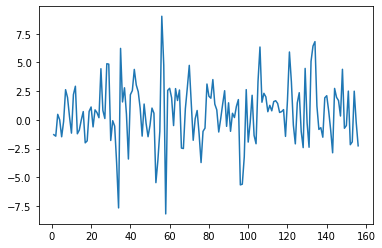

In [6]:
diffData = data-data.shift(1)
diffData = diffData.dropna()
diffData.plot()
adfuller(diffData)

c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:title={'center':'Data after one-lag differencing'}>

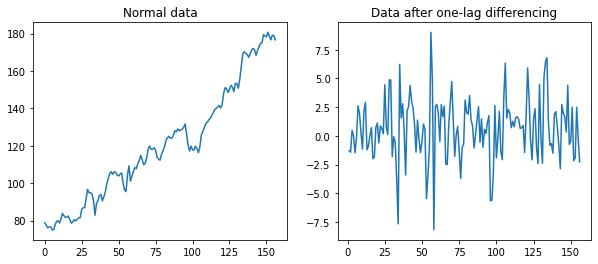

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# plt.figu
data.plot(title="Normal data")
plt.subplot(1, 2, 2)
diffData.plot(title="Data after one-lag differencing")

## Plot PACF using the differenced to determine AR

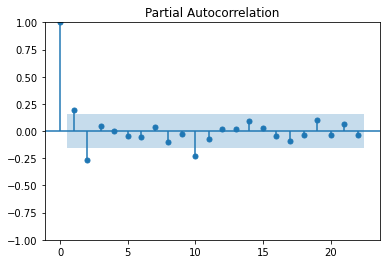

In [8]:
plot_pacf(diffData, method="ywm");

## Plot ACF using the differenced to determine MA

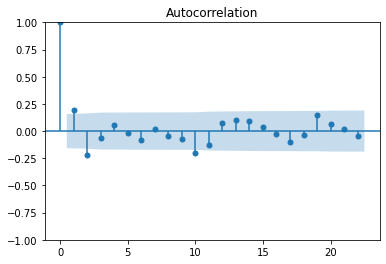

In [9]:
plot_acf(diffData);

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  157
Model:                 ARIMA(4, 2, 3)   Log Likelihood                -361.047
Date:                Tue, 10 May 2022   AIC                            738.094
Time:                        23:37:14   BIC                            762.441
Sample:                             0   HQIC                           747.983
                                - 157                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4815      0.066    -22.376      0.000      -1.611      -1.352
ar.L2         -0.7920      0.114     -6.924      0.000      -1.016      -0.568
ar.L3         -0.2540      0.118     -2.144      0.0

c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


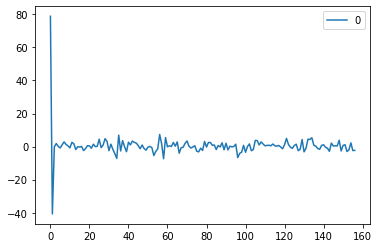

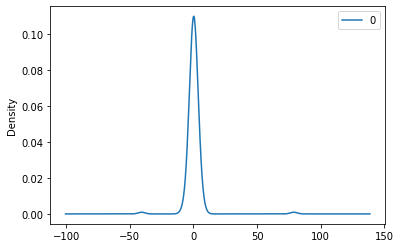

                0
count  157.000000
mean     0.454509
std      7.507325
min    -40.726363
25%     -1.240725
50%      0.270626
75%      1.561228
max     78.872499


<AxesSubplot:>

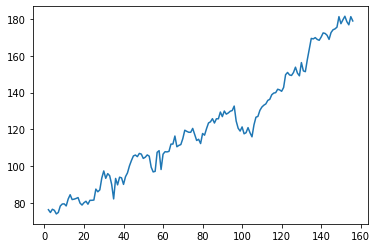

In [10]:
model = ARIMA(data, order=(4,2,3))
model_fit = model.fit()
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())
model_fit.predict(start=2).plot() # No spikes at the start when start=d??

In [11]:
train = data[:130]
test = data[130:]

In [12]:
train[0]

78.87249946594238

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  130
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -304.637
Date:                Tue, 10 May 2022   AIC                            615.275
Time:                        23:37:15   BIC                            623.854
Sample:                             0   HQIC                           618.761
                                - 130                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2701      0.183     -1.479      0.139      -0.628       0.088
ma.L1          0.5733      0.162      3.533      0.000       0.255       0.891
sigma2         6.5805      0.627     10.492      0.0

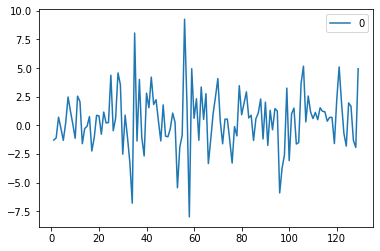

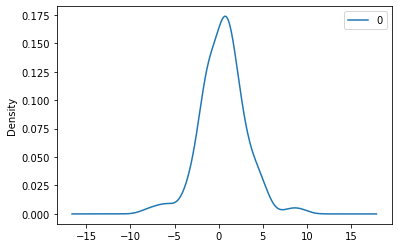

In [13]:
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
summary = model_fit.summary()
print(summary)
residuals = pd.DataFrame(model_fit.resid[1:])
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())


<AxesSubplot:>

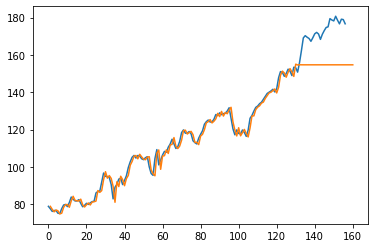

In [14]:
data.plot()
mfit = model_fit.predict(start=1, end=160)
mfit.plot()

In [15]:
# Brute force to find the best p, d, q while looking at AIC
def getBestParams(data, p_max=5, d_max=3, q_max=5):
    best_aic = np.inf
    bestParams = [1, 1, 1]
    for p in range(1, p_max+1):
        for d in range(1, d_max+1):
            for q in range(1, q_max+1):
                model = ARIMA(data, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit()
                summary = model_fit.summary()
                info = pd.read_html(summary.tables[0].as_html())[0]
                aic = info[3][2]
                # print(f"AIC: {aic}, {[p, d, q]}")
                if best_aic > aic:
                    print(f"AIC: {aic}, {[p, d, q]}")
                    best_aic = aic
                    bestParams = [p, d, q]
    print(best_aic)
    print(bestParams[0], bestParams[1], bestParams[2])
    return bestParams[0], bestParams[1], bestParams[2]


In [16]:
best_p, best_d, best_q = getBestParams(train, p_max=5, d_max=3, q_max=5)

AIC: 607.412, [1, 1, 1]
AIC: 604.378, [1, 1, 2]
AIC: 602.155, [1, 1, 3]
AIC: 598.485, [1, 1, 4]
AIC: 594.953, [1, 1, 5]
AIC: 592.943, [1, 2, 4]
AIC: 589.664, [1, 2, 5]


c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC: 588.925, [2, 2, 5]


c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

588.925
2 2 5


c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 2 5
                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  130
Model:                 ARIMA(2, 2, 5)   Log Likelihood                -286.462
Date:                Tue, 10 May 2022   AIC                            588.925
Time:                        23:37:26   BIC                            611.357
Sample:                             0   HQIC                           598.036
                                - 130                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4149      0.222     -6.359      0.000      -1.851      -0.979
ar.L2         -0.6768      0.198     -3.414      0.001      -1.065      -0.288
ma.L1          0.6787    133.700      0.005   

<AxesSubplot:>

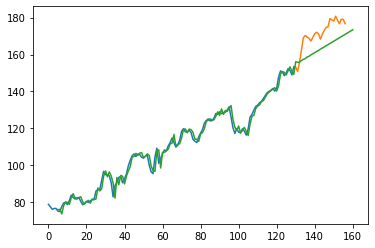

In [17]:
print(best_p, best_d, best_q)
model = ARIMA(train, order=(best_p, best_d, best_q), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()
summary = model_fit.summary()
print(summary)
train.plot()
test.plot()
model_fit.predict(start=best_q, end=160).plot()